In [129]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from tqdm import trange
import pandas as pd

In [130]:
sys.path.append('/home/raffaele/Documents/ml-project/src/')

In [131]:
from torch_utility import *

## Import Dataset

In [152]:
data = np.genfromtxt('/home/raffaele/Documents/ml-project/cup/ML-CUP20-TR.csv', delimiter=',', dtype=np.float32)
X = data[:, 1:-2]
y = data[:, -2:]

In [153]:
print(X.shape)
print(y.shape)

(1524, 10)
(1524, 2)


### Split train set and Validation Set

In [154]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.20, random_state=42)

In [155]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)

(1219, 10)
(1219, 2)
(305, 10)
(305, 2)


In [156]:
Xtrain = Xtrain.astype('float32')
ytrain = ytrain.astype('float32')

Xval = Xval.astype('float32')
yval = yval.astype('float32')

## Define Models

In [157]:
class Net(nn.Module):

    def __init__(self, num_units1, num_units2):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(10,num_units1)
        self.hidden1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units2,2)

    def forward(self, x):
        x = torch.tanh(self.input_layer(x))
        x = torch.tanh(self.hidden1(x))
        x = self.output(x)
        return x

In [138]:
net = Net(50,20)
print(net)

Net(
  (input_layer): Linear(in_features=10, out_features=50, bias=True)
  (hidden1): Linear(in_features=50, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=2, bias=True)
)


### Initialize the weights

In [139]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
        
net.apply(init_weights)

Net(
  (input_layer): Linear(in_features=10, out_features=50, bias=True)
  (hidden1): Linear(in_features=50, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=2, bias=True)
)

In [140]:
# def MEE(y_real, y_pred): 
#     return torch.div(torch.sum(F.pairwise_distance(y_real, y_pred, p=2)), len(y_real))

In [141]:
class MEE(torch.nn.Module):

    def __init__(self):
        super(MEE, self).__init__()

    def forward(self, y_true, y_pred):
#         return torch.mean(torch.linalg.norm(y_pred - y_true))
#         return torch.mean(torch.cdist(y_true, y_pred, p=2))
        return torch.div(torch.sum(torch.pairwise_distance(y_true, y_pred)), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true, ord=None), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true), len(y_true))

In [142]:
from sklearn.metrics import euclidean_distances

def mean_euclidean_error(y_true, y_pred):
    assert y_true.shape == y_pred.shape
#     return np.mean(np.linalg.norm(y_pred - y_true))
#     return np.divide(np.linalg.norm(y - y_real), len(y_real))
#     return np.mean(euclidean_distances(y_true, y_pred))
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1)) #utilizzare questa loss la prossima grid

In [117]:
from skorch import NeuralNetRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

Network = NeuralNetRegressor(net, verbose=0, train_split=False)

params = {
    'max_epochs':[300],
#     'module__activation':[torch.relu],
    'module__num_units1' :[20, 50, 100, 150],
    'module__num_units2' :[20, 30, 40, 10],
    'lr': [0.01, 0.001, 0.0001, 0.1],
    'batch_size': [64, 128, 256],
    'criterion' : [MEE],
    'optimizer': [optim.SGD],
    'optimizer__weight_decay': [0.0001, 0.001, 0.00001],
    'optimizer__momentum': [0.2, 0.4, 0.6, 0.8],
#     'optimizer__nesterov':[True, False]
}


neg_mean_euclidean_error = make_scorer(mean_euclidean_error, greater_is_better=False)
# The grid search module is instantiated
gs = GridSearchCV(Network, params
                  , refit=False,
                  scoring=neg_mean_euclidean_error,
                  cv=3,
                  return_train_score=True,
                  n_jobs=-1,
                  verbose=2)
# Initialize grid search
gs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 2304 candidates, totalling 6912 fits


GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=Net(
    (input_layer): Linear(in_features=10, out_features=50, bias=True)
    (hidden1): Linear(in_features=50, out_features=20, bias=True)
    (output): Linear(in_features=20, out_features=2, bias=True)
  ),
),
             n_jobs=-1,
             param_grid={'batch_size': [64, 128, 256],
                         'criterion': [<class '__m...
                         'lr': [0.01, 0.001, 0.0001, 0.1], 'max_epochs': [300],
                         'module__num_units1': [20, 50, 100, 150],
                         'module__num_units2': [20, 30, 40, 10],
                         'optimizer': [<class 'torch.optim.sgd.SGD'>],
                         'optimizer__momentum': [0.2, 0.4, 0.6, 0.8],
                         'optimizer__weight_decay': [0.0001, 0.001, 1e-05]},
             refit=False, return_train_score=True,
             scoring=make_scorer(mean_euclidean_error, great

In [119]:
df = pd.DataFrame(gs.cv_results_)[['param_module__num_units1',
                                   'param_module__num_units2',
                                   'param_batch_size',
                                   'param_lr', 
                                     'param_max_epochs', 'param_optimizer','param_optimizer__weight_decay',
                                   'param_optimizer__momentum', 
#                                    'param_optimizer__nesterov',
                                     'mean_train_score', 'mean_test_score', 
                                   'std_train_score','mean_fit_time','std_fit_time',
                                     'rank_test_score']].sort_values(by='rank_test_score')
df.rename(columns={'param_module__num_units1': '#Units1',
                   'param_module__num_units2': '#Units2',
                   'param_max_epochs': 'max_epochs',
                   'param_lr': 'lr',
                   'param_batch_size': 'batch_size',
                   'param_optimizer': 'optimizer',
                   'param_optimizer__momentum': 'momentum',
#                    'param_optimizer__nesterov':'nesterov',
                   'param_optimizer__weight_decay': 'weight_decay',
                   'std_train_score' : 'std_train_score',
                   'mean_test_score': 'mean_val_score',
                   'rank_test_score': 'rank_val_score'}, inplace=True)
df.mean_train_score *= -1
df.mean_val_score *= -1

def highlight_equal(s, value, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == value
    return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

df.head(30).style.apply(highlight_equal, value=1, 
                        column=['rank_val_score'], axis=1).hide_index()

#Units1,#Units2,batch_size,lr,max_epochs,optimizer,weight_decay,momentum,mean_train_score,mean_val_score,std_train_score,mean_fit_time,std_fit_time,rank_val_score
100,30,128,0.010000,300,,0.000100,0.600000,2.390754,2.801776,0.066425,6.735029,0.048729,1
50,40,128,0.010000,300,,0.001000,0.600000,2.403434,2.804529,0.097309,6.530352,0.070737,2
150,30,64,0.010000,300,,0.001000,0.400000,2.318314,2.805741,0.097018,9.636379,0.128795,3
150,40,128,0.010000,300,,0.001000,0.800000,2.102182,2.808632,0.065231,6.882976,0.068041,4
150,40,128,0.010000,300,,0.000100,0.600000,2.322591,2.808824,0.079242,6.939281,0.026309,5
100,40,64,0.010000,300,,0.000010,0.600000,2.182211,2.810952,0.073444,9.400847,0.042449,6
150,40,128,0.010000,300,,0.000100,0.800000,2.078329,2.811017,0.074752,6.823612,0.028070,7
50,40,64,0.010000,300,,0.000100,0.400000,2.328552,2.821787,0.090566,9.199880,0.066571,8
100,40,64,0.010000,300,,0.001000,0.400000,2.319708,2.824220,0.121763,9.470558,0.041071,9
100,40,128,0.010000,300,,0.001000,0.800000,2.127309,2.824938,0.065886,6.722210,0.062503,10


In [176]:
df.to_csv('../../grid_results/gridSearch_2LayersResults.csv', index=False)

In [108]:
gs.param_grid

{'max_epochs': [300],
 'module__num_units': [50, 70, 80, 100],
 'lr': [0.01, 0.013, 0.016, 0.019],
 'batch_size': [64, 128],
 'criterion': [__main__.MEE],
 'optimizer': [torch.optim.sgd.SGD],
 'optimizer__weight_decay': [0.0009, 0.00095, 0.001],
 'optimizer__momentum': [0.8, 0.85, 0.9, 0.95],
 'optimizer__nesterov': [True, False]}

In [154]:
Network.get_params().keys()

dict_keys(['module', 'criterion', 'optimizer', 'lr', 'max_epochs', 'batch_size', 'iterator_train', 'iterator_valid', 'dataset', 'train_split', 'callbacks', 'predict_nonlinearity', 'warm_start', 'verbose', 'device', 'callbacks__epoch_timer', 'callbacks__train_loss', 'callbacks__train_loss__name', 'callbacks__train_loss__lower_is_better', 'callbacks__train_loss__on_train', 'callbacks__valid_loss', 'callbacks__valid_loss__name', 'callbacks__valid_loss__lower_is_better', 'callbacks__valid_loss__on_train', 'callbacks__print_log', 'callbacks__print_log__keys_ignored', 'callbacks__print_log__sink', 'callbacks__print_log__tablefmt', 'callbacks__print_log__floatfmt', 'callbacks__print_log__stralign'])

In [155]:
print(gs.best_params_)

{'batch_size': 64, 'criterion': <class '__main__.MEE'>, 'lr': 0.001, 'max_epochs': 300, 'module__num_units1': 50, 'module__num_units2': 30, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__momentum': 0.8, 'optimizer__weight_decay': 0.0001}


In [156]:
gs.best_score_

-3.2546486854553223

In [178]:
from skorch import NeuralNetRegressor
test_net = Net(50,30)
nett = NeuralNetRegressor(test_net, max_epochs=1000,
                          lr=0.001,
                          batch_size=64,
                          optimizer=optim.SGD,
                          optimizer__momentum=0.8,
#                           optimizer__weight_decay=0.0001,
                          optimizer__nesterov = True,
                          criterion=torch.nn.MSELoss)
# Training
nett.fit(Xtrain, ytrain)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     1395.1952      396.8841  0.3706
      2      171.6028       69.3850  0.0537
      3       58.9402       47.5359  0.0475
      4       47.8354       41.7820  0.0470
      5       41.3141       34.7099  0.0485
      6       34.3749       28.5421  0.0485
      7       28.1168       22.8456  0.0490
      8       22.6351       18.1239  0.0546
      9       18.3093       14.8300  0.0527
     10       15.4961       12.9133  0.0475
     11       13.7079       11.7474  0.0476
     12       12.4600       10.9782  0.0465
     13       11.5267       10.4343  0.0474
     14       10.8074       10.0304  0.0655
     15       10.2461        9.7217  0.0509
     16        9.8023        9.4799  0.1261
     17        9.4452        9.2858  0.0499
     18        9.1525        9.1259  0.0495
     19        8.9084        8.9909  0.0519
     20        8.7017        8.8744  0.0561
     21        8.5240        8.7

    133        5.4556        7.1647  0.0494
    134        5.4474        7.1653  0.0398
    135        5.4394        7.1660  0.0551
    136        5.4314        7.1667  0.0434
    137        5.4235        7.1675  0.0458
    138        5.4156        7.1684  0.0416
    139        5.4079        7.1693  0.0405
    140        5.4002        7.1702  0.0381
    141        5.3925        7.1712  0.0572
    142        5.3850        7.1723  0.0439
    143        5.3774        7.1734  0.0385
    144        5.3700        7.1745  0.0412
    145        5.3626        7.1757  0.0419
    146        5.3553        7.1770  0.0388
    147        5.3480        7.1783  0.0411
    148        5.3408        7.1796  0.0417
    149        5.3337        7.1809  0.0429
    150        5.3266        7.1823  0.0441
    151        5.3195        7.1838  0.0403
    152        5.3125        7.1853  0.0418
    153        5.3056        7.1868  0.0425
    154        5.2987        7.1883  0.0410
    155        5.2919        7.1

    288        4.5752        7.3556  0.0549
    289        4.5706        7.3573  0.1192
    290        4.5661        7.3590  0.0430
    291        4.5615        7.3607  0.0554
    292        4.5570        7.3625  0.0503
    293        4.5525        7.3643  0.0524
    294        4.5479        7.3661  0.0540
    295        4.5434        7.3679  0.0593
    296        4.5390        7.3698  0.0448
    297        4.5345        7.3717  0.0377
    298        4.5300        7.3736  0.0415
    299        4.5256        7.3756  0.0383
    300        4.5211        7.3776  0.0479
    301        4.5167        7.3797  0.0402
    302        4.5123        7.3817  0.0405
    303        4.5079        7.3838  0.0394
    304        4.5035        7.3860  0.0406
    305        4.4991        7.3882  0.0388
    306        4.4948        7.3904  0.0415
    307        4.4904        7.3926  0.0394
    308        4.4860        7.3949  0.0421
    309        4.4817        7.3972  0.0406
    310        4.4774        7.3

    443        3.9589        7.8914  0.0489
    444        3.9554        7.8948  0.0435
    445        3.9520        7.8982  0.0411
    446        3.9486        7.9016  0.0396
    447        3.9452        7.9050  0.0437
    448        3.9418        7.9083  0.0406
    449        3.9384        7.9117  0.0482
    450        3.9351        7.9150  0.0543
    451        3.9317        7.9184  0.0511
    452        3.9283        7.9217  0.0442
    453        3.9250        7.9250  0.0519
    454        3.9217        7.9283  0.0600
    455        3.9183        7.9316  0.0441
    456        3.9150        7.9349  0.0437
    457        3.9117        7.9381  0.0473
    458        3.9084        7.9414  0.0441
    459        3.9051        7.9447  0.0485
    460        3.9018        7.9479  0.0510
    461        3.8985        7.9512  0.0427
    462        3.8952        7.9544  0.0447
    463        3.8919        7.9576  0.0470
    464        3.8887        7.9608  0.0496
    465        3.8854        7.9

    598        3.4944        8.3578  0.0491
    599        3.4917        8.3605  0.0412
    600        3.4890        8.3633  0.0405
    601        3.4863        8.3660  0.0407
    602        3.4835        8.3688  0.0382
    603        3.4808        8.3715  0.0424
    604        3.4781        8.3742  0.0397
    605        3.4754        8.3770  0.0533
    606        3.4727        8.3797  0.0400
    607        3.4700        8.3824  0.0421
    608        3.4673        8.3851  0.0435
    609        3.4646        8.3879  0.0422
    610        3.4619        8.3906  0.0400
    611        3.4592        8.3933  0.0432
    612        3.4565        8.3960  0.0417
    613        3.4538        8.3987  0.0423
    614        3.4511        8.4014  0.0415
    615        3.4484        8.4040  0.0411
    616        3.4458        8.4067  0.0409
    617        3.4431        8.4094  0.0419
    618        3.4404        8.4121  0.0426
    619        3.4377        8.4147  0.0447
    620        3.4350        8.4

    753        3.0904        8.7438  0.1044
    754        3.0879        8.7462  0.1039
    755        3.0853        8.7486  0.0383
    756        3.0827        8.7510  0.0381
    757        3.0801        8.7534  0.0363
    758        3.0775        8.7559  0.0367
    759        3.0749        8.7583  0.0405
    760        3.0723        8.7607  0.0507
    761        3.0697        8.7632  0.0467
    762        3.0671        8.7656  0.1254
    763        3.0645        8.7681  0.0406
    764        3.0620        8.7705  0.0392
    765        3.0594        8.7730  0.0423
    766        3.0568        8.7755  0.0392
    767        3.0542        8.7779  0.0389
    768        3.0516        8.7804  0.0382
    769        3.0490        8.7829  0.0400
    770        3.0464        8.7854  0.0452
    771        3.0438        8.7879  0.0425
    772        3.0412        8.7904  0.0428
    773        3.0386        8.7929  0.0449
    774        3.0360        8.7955  0.0818
    775        3.0334        8.7

    908        2.6902        9.2230  0.1232
    909        2.6877        9.2266  0.0567
    910        2.6852        9.2302  0.0638
    911        2.6827        9.2338  0.0548
    912        2.6802        9.2373  0.0565
    913        2.6777        9.2409  0.0540
    914        2.6752        9.2445  0.0631
    915        2.6727        9.2480  0.0519
    916        2.6702        9.2516  0.0684
    917        2.6677        9.2552  0.0950
    918        2.6652        9.2587  0.0556
    919        2.6627        9.2623  0.0722
    920        2.6602        9.2658  0.0643
    921        2.6577        9.2694  0.0731
    922        2.6552        9.2729  0.0663
    923        2.6527        9.2764  0.0609
    924        2.6502        9.2800  0.0600
    925        2.6477        9.2835  0.0626
    926        2.6452        9.2870  0.0625
    927        2.6427        9.2906  0.0513
    928        2.6402        9.2941  0.0686
    929        2.6377        9.2976  0.0604
    930        2.6352        9.3

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (input_layer): Linear(in_features=10, out_features=50, bias=True)
    (hidden1): Linear(in_features=50, out_features=30, bias=True)
    (output): Linear(in_features=30, out_features=2, bias=True)
  ),
)

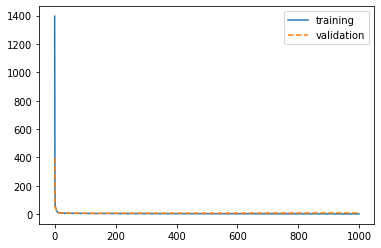

In [183]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.legend()
plt.show()

In [184]:
prova = nett.predict(Xval)

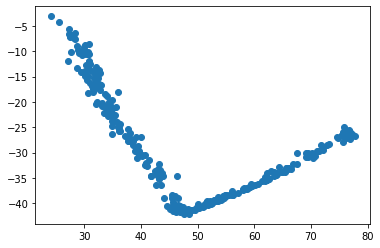

In [185]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

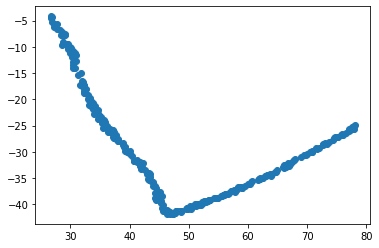

In [186]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

In [187]:
mean_euclidean_error(prova, yval)

3.4315946

In [170]:
from skorch import NeuralNetRegressor
test_net = Net(100, 30)
nett = NeuralNetRegressor(test_net, max_epochs=300,
                          lr=0.01,
                          batch_size=128,
                          optimizer=optim.SGD,
                          optimizer__momentum=0.6,
                          optimizer__weight_decay=0.0001,
#                           optimizer__nesterov = True,
                          criterion=MEE)
# Training
nett.fit(Xtrain, ytrain)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       57.0871       55.3163  0.0552
      2       56.6632       54.8167  0.0383
      3       56.0905       54.1196  0.0383
      4       55.2551       53.0561  0.0386
      5       53.9592       51.3931  0.0385
      6       51.9527       48.8782  0.0386
      7       49.0164       45.3655  0.0389
      8       45.0937       40.9244  0.0446
      9       40.3433       35.8435  0.0396
     10       35.1332       30.6305  0.0368
     11       30.0334       25.9395  0.0388
     12       25.6841       22.3192  0.0415
     13       22.5383       19.9475  0.0391
     14       20.2662       17.7484  0.0402
     15       17.9384       15.6079  0.0395
     16       15.9165       13.9012  0.0869
     17       14.2876       12.5657  0.0385
     18       12.9444       11.4882  0.0423
     19       11.8336       10.6255  0.0685
     20       10.9374        9.9651  0.0400
     21       10.2429        9.4

    132        2.8020        3.0291  0.0471
    133        2.7965        3.0259  0.0329
    134        2.7910        3.0228  0.0347
    135        2.7857        3.0198  0.0355
    136        2.7804        3.0169  0.0322
    137        2.7751        3.0140  0.0310
    138        2.7699        3.0113  0.0333
    139        2.7648        3.0087  0.0304
    140        2.7596        3.0059  0.0527
    141        2.7544        3.0030  0.0515
    142        2.7492        3.0001  0.0444
    143        2.7439        2.9973  0.0346
    144        2.7386        2.9945  0.0427
    145        2.7334        2.9916  0.0685
    146        2.7283        2.9889  0.0606
    147        2.7234        2.9863  0.0713
    148        2.7187        2.9841  0.0652
    149        2.7141        2.9821  0.0543
    150        2.7096        2.9800  0.0348
    151        2.7053        2.9783  0.0322
    152        2.7007        2.9765  0.0313
    153        2.6965        2.9749  0.0322
    154        2.6921        2.9

    280        2.3852        2.9483  0.0294
    281        2.3811        2.9543  0.0305
    282        2.3835        2.9520  0.0267
    283        2.3793        2.9564  0.0267
    284        2.3787        2.9579  0.0267
    285        2.3774        2.9557  0.0280
    286        2.3766        2.9550  0.0268
    287        2.3759        2.9545  0.0266
    288        2.3727        2.9532  0.0314
    289        2.3698        2.9567  0.0267
    290        2.3664        2.9575  0.0272
    291        2.3680        2.9586  0.0270
    292        2.3667        2.9594  0.0264
    293        2.3678        2.9573  0.0269
    294        2.3661        2.9553  0.0268
    295        2.3633        2.9578  0.0268
    296        2.3626        2.9545  0.0264
    297        2.3586        2.9572  0.0274
    298        2.3588        2.9616  0.0272
    299        2.3610        2.9627  0.0273
    300        2.3592        2.9664  0.0344


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (input_layer): Linear(in_features=10, out_features=100, bias=True)
    (hidden1): Linear(in_features=100, out_features=30, bias=True)
    (output): Linear(in_features=30, out_features=2, bias=True)
  ),
)

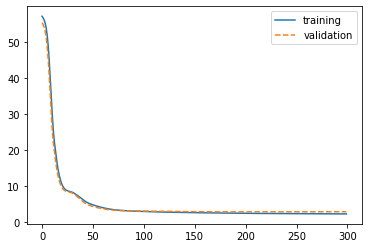

In [171]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
# plt.ylim(2,4)
# plt.xlim(100,1000)
plt.legend()
plt.show()

In [172]:
prova = nett.predict(Xval)

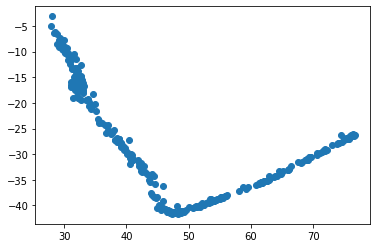

In [173]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

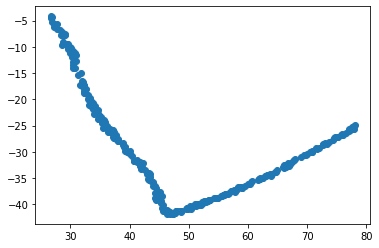

In [174]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

In [175]:
mean_euclidean_error(prova, yval)

3.1424897